## Segmentation of User Interaction Logs using Time Series Methods

A demo case used for the idea paper at CAISE 2025

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import stumpy
from stumpy import config

import util.util

import matplotlib.pyplot as plt
import pm4py
import webbrowser
import os

import random

import time

#### Data Gathering

Gathering of the original Leno data from https://figshare.com/articles/dataset/UI_logs/12543587

In [2]:
file_path = '../logs/Leno/'
srrt_plus_filename = "SR_RT_joint.csv"
srrt_parallel_filename = "SR_RT_parallel.csv"

encoding_method = "utf-8"
seperator = ";"

srrt_plus_log = pd.read_csv(file_path + srrt_plus_filename, encoding=encoding_method, sep=seperator)
srrt_parallel_log = pd.read_csv(file_path + srrt_parallel_filename, encoding=encoding_method, sep=seperator)

#### Execution of Log Generation for Discovery

Generating two extended logs
1. Adding a case id for all existing cases
2. Adding 50 random actions between all cases to simulate long time recording

In [3]:
def add_caseid_column(df: pd.DataFrame, random_insert: bool = True) -> pd.DataFrame:
    """
    Adds a "caseid" column, incrementing it when a specific URL or event type is found.
    """
    target_url: str = "https://forms.zoho.com/universityofmelbourne/form/NewRecord/thankyou"
    target_event: str = "createNewTab"
    caseid: int = 1
    caseid_list: list[int] = []
    
    if "caseid" in df.columns:
        df = df.drop(columns=["caseid"])

    for index, row in df.iterrows():
        caseid_list.append(caseid)
        if row["url"] == target_url or ("eventType" in df.columns and row["eventType"] == target_event):
            caseid += 1
    
    df.insert(0, "caseid", caseid_list)
    
    if random_insert:
        return insert_random_rows(df)
    else:
        return df

def insert_random_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Inserts 50 random rows at each caseid transition point.
    """
    new_df_parts: list[pd.DataFrame] = []
    prev_caseid = df.iloc[0]["caseid"]
    
    for i in range(len(df)):
        if i > 0 and df.iloc[i]["caseid"] != prev_caseid:
            new_df_parts.extend(generate_random_rows(df, 50))
        new_df_parts.append(pd.DataFrame([df.iloc[i]]))
        prev_caseid = df.iloc[i]["caseid"]
    
    return pd.concat(new_df_parts, ignore_index=True)

import random

def generate_random_rows(df: pd.DataFrame, num_rows: int) -> list[pd.DataFrame]:
    """
    Generates a list of random rows from existing DataFrame values, and adds random data for URL,
    content, and target.workbookName columns.
    """
    shuffled_rows: list[pd.DataFrame] = []
    columns_to_shuffle = [col for col in df.columns if col != "caseid"]
    
    # Predefined lists for random data
    random_actions = [
        "doubleClick", "drag", "closeWindow"
    ]
    random_urls = [
        "https://example.com", "https://example.org", "https://example.net", "", " "
    ]
    random_content = [
        "Lorem ipsum dolor sit amet.", "This is a random content example.", 
        "Random text for data generation.", "", " "
    ]
    random_file_names = [
        "report_final.xlsx", "data_analysis.csv", "project_notes.pdf", "", " "
    ]
    
    for _ in range(num_rows):
        # Shuffle other columns' values
        random_row: dict = {col: random.choice(df[col].tolist()) for col in columns_to_shuffle}
        
        # Add random values for specific columns
        random_row["eventType"] = random.choice(random_actions)  # Random URL
        random_row["url"] = random.choice(random_urls)  # Random URL
        random_row["content"] = random.choice(random_content)  # Random personal content
        random_row["target.workbookName"] = random.choice(random_file_names)  # Random file name
        
        shuffled_rows.append(pd.DataFrame([random_row]))
    
    return shuffled_rows


# Add Caseids for discovery and random noise
srrt_plus_log = add_caseid_column(srrt_plus_log)
srrt_parallel_log = add_caseid_column(srrt_parallel_log)
#print(srrt_plus_log)

# Storing Files
#full_path_srrt_plus = file_path + "extended_" + srrt_plus_filename
#full_path_srrt_parallel = file_path + "extended_" + srrt_parallel_filename
#srrt_plus_log.to_csv(full_path_srrt_plus, index=False) 
#srrt_parallel_log.to_csv(full_path_srrt_parallel, index=False) 

      caseid                 timeStamp userID targetApp    eventType  \
0        1.0  2019-10-21T00:10:09.640Z  vleno     Excel     copyCell   
1        1.0  2019-10-21T00:10:12.216Z  vleno    Chrome        paste   
2        1.0  2019-10-21T00:10:13.281Z  vleno    Chrome    editField   
3        1.0  2019-10-21T00:10:16.269Z  vleno     Excel     copyCell   
4        1.0  2019-10-21T00:10:18.810Z  vleno    Chrome        paste   
...      ...                       ...    ...       ...          ...   
9589   100.0  2020-02-25T02:55:16.084Z  vleno     Excel     copyCell   
9590   100.0  2020-02-25T02:55:18.065Z  vleno    Chrome        paste   
9591   100.0  2020-02-25T02:55:18.574Z  vleno    Chrome    editField   
9592   100.0  2020-02-25T02:55:20.800Z  vleno    Chrome  clickButton   
9593   100.0  2020-02-25T02:55:21.198Z  vleno    Chrome  form_submit   

                                                    url content  \
0                                                   NaN    John   
1

### Time Series Discovery

Based on the context columns the discovery will be executed

In [ ]:
log_to_discover = srrt_plus_log
log_to_discover = srrt_parallel_log

# ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id"] # Leno Attributes
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
NumberOfMotifsToDiscover = 10

# ---- Reading the File ----
uiLog_Encoding_method = 3 # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Ecnoding
uiLog = util.util.encoding_UiLog(log_to_discover,orderedColumnsList=ContextColumns,encoding=uiLog_Encoding_method)

# ---- Generate Ground Truth ----
def generate_caseid_list(df: pd.DataFrame) -> list[int]:
    """
    Generates a list of tuples where each tuple contains a caseid and the row index where that caseid is first encountered.
    """
    caseid_list_with_indices = []
    seen_caseids = set()  # To keep track of the caseid values we've already encountered
    
    for index, caseid in df['caseid'].items():
        if pd.notna(caseid) and caseid not in seen_caseids:
            caseid_list_with_indices.append(index)
            seen_caseids.add(caseid)  # Add caseid to the set to track it
    
    return caseid_list_with_indices

groundTruth = generate_caseid_list(log_to_discover)

# ---- Time Series Mining ----
tm_matrix, event_series = util.util.discover_motifs(uiLog, size, normalize=True)
# The motifs have to be exclusive, thus, no one activity must be part of a routine already discovered
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover)
# Identify the outlier
discord_idx = np.argsort(tm_matrix[:, 0])[-1]
print(f"Discovered: {np.sort(top_motifs[1][0])}")

#### Quality Measures

In [30]:
print(f"Ground Truth:{np.sort(groundTruth)}")

insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(top_motifs[1][0]), (size/2))
ground_truth_sum = len(groundTruth)
true_positives = len(insert_spots)
false_positives = NumberOfMotifsToDiscover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

Ground Truth:[   0   79  160  239  320  401  482  561  643  723  804  885  964 1045
 1126 1208 1289 1368 1451 1530 1608 1689 1771 1852 1933 2012 2091 2172
 2253 2334 2415 2497 2578 2659 2740 2821 2903 2984 3065 3146 3227 3308
 3389 3470 3551 3632 3713 3794 3875 3956 4037 4148 4260 4372 4484 4596
 4708 4821 4933 5045 5157 5269 5381 5493 5605 5717 5832 5944 6056 6168
 6282 6394 6506 6618 6730 6842 6954 7066 7178 7290 7404 7516 7628 7740
 7852 7964 8076 8188 8300 8412 8524 8636 8749 8861 8973 9085 9198 9310
 9422 9534]
Precision: 0.0
Recall: 0.0
F1-Score: 0


#### Visualisation

c:\Users\tomho\OneDrive\Documents\VSCode\TSMDforUILogs\JupyterNotebooks\..\util\util.py:214: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, window_df], ignore_index=True)


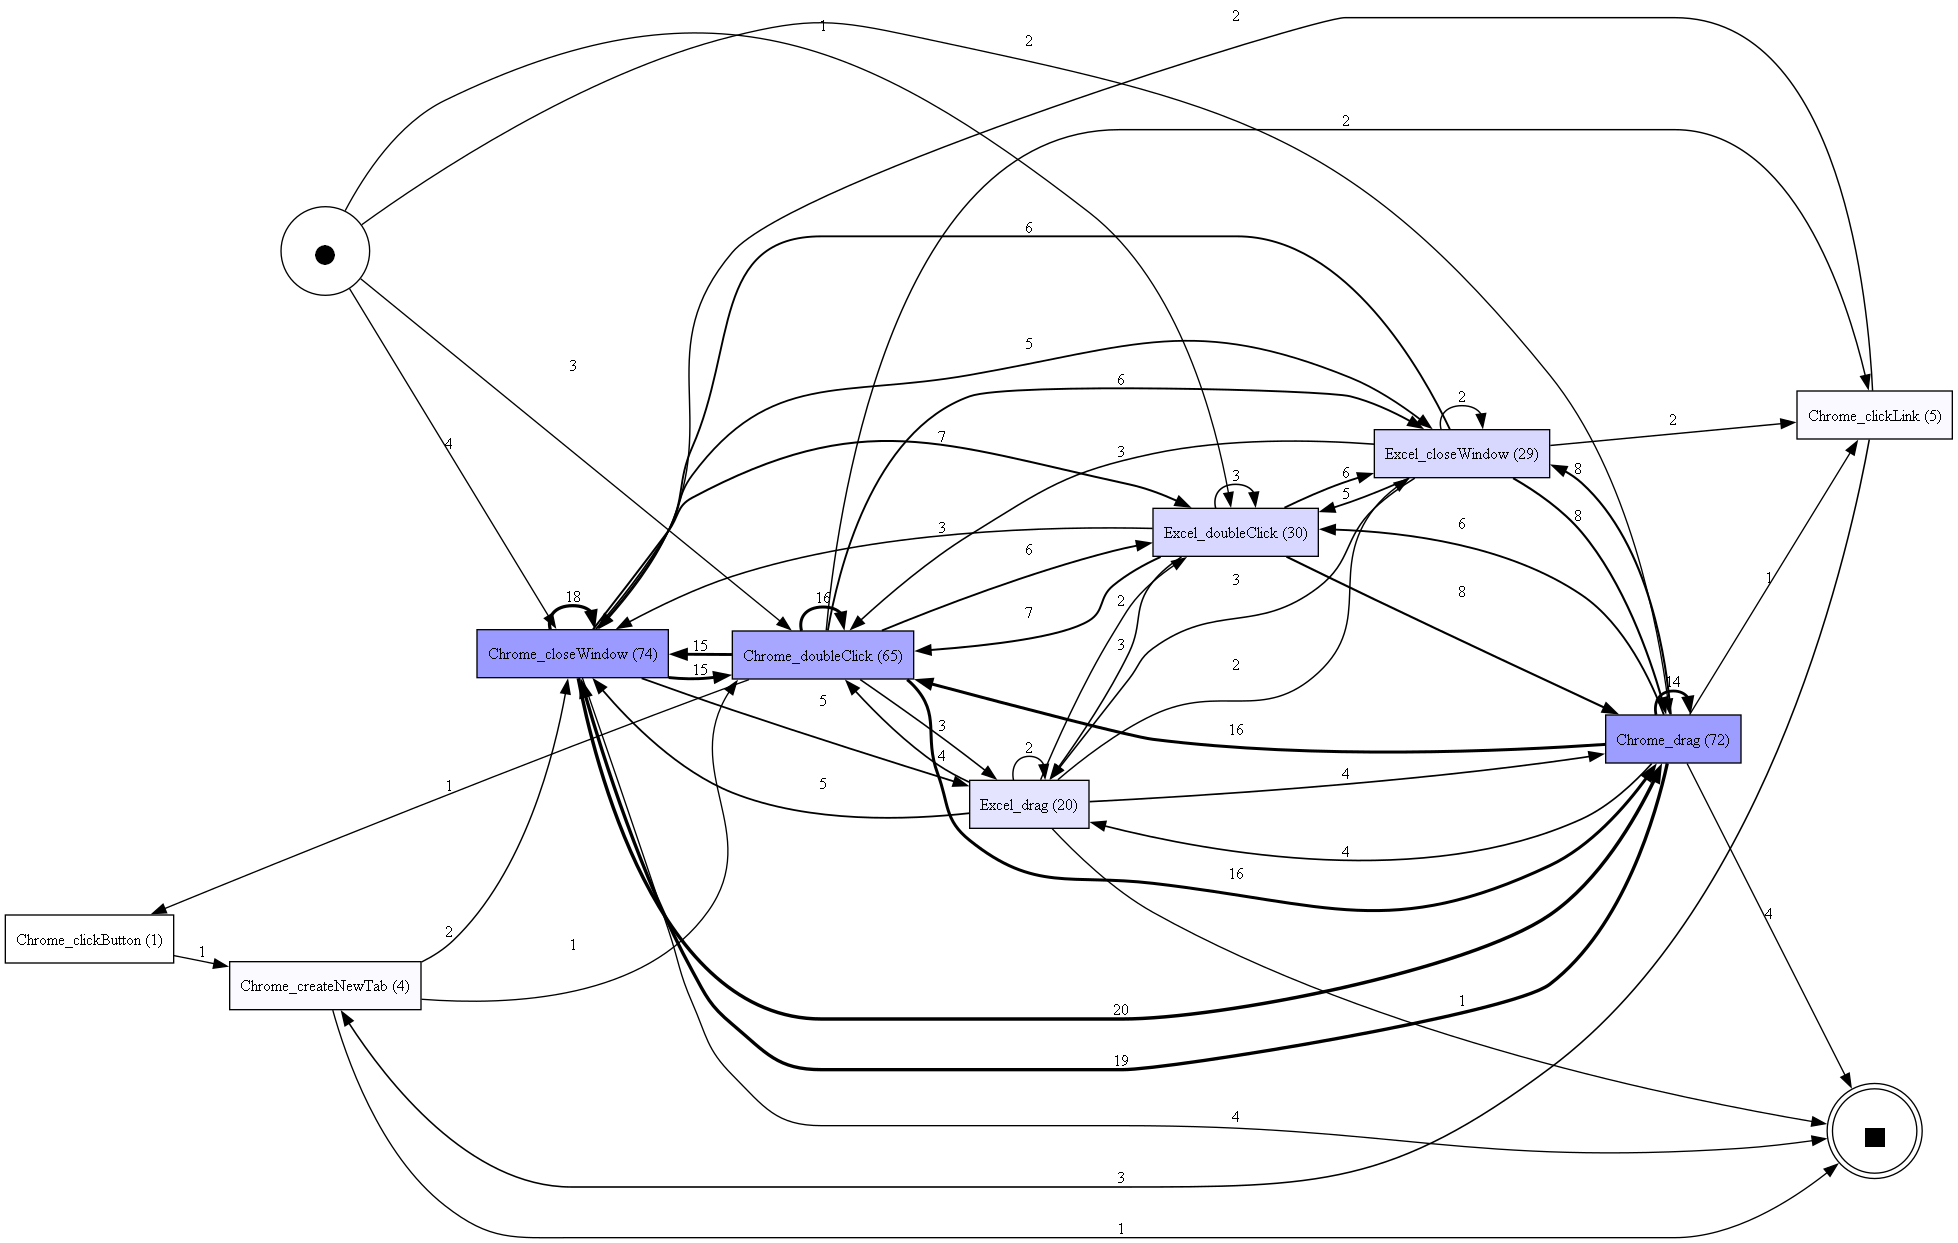

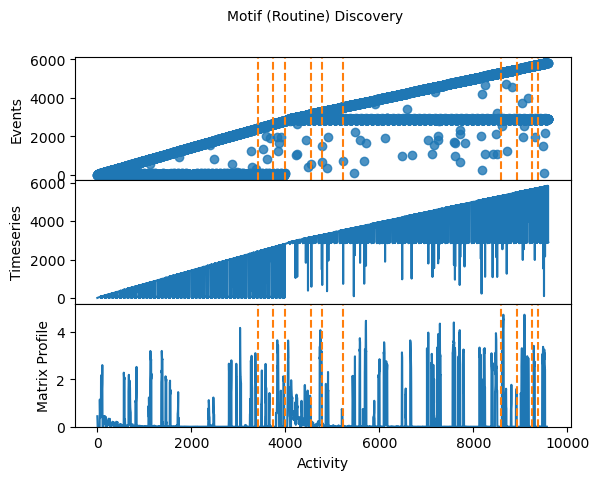

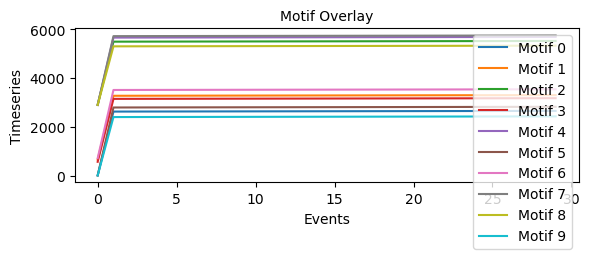

In [21]:
# ---- DFG Mining ----
caseuiLog = util.util.reduceLogToDiscovered(uiLog,top_motifs[1][0],size)
end_time = time.time()

cols = ["targetApp","eventType"]
caseuiLog["concept:name"] = caseuiLog[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
caseuiLog["time:timestamp"] = caseuiLog["timeStamp"]
caseuiLog['case:concept:name'] = caseuiLog['case:concept:name'].astype('int64')
pm4pyDf = pm4py.format_dataframe(caseuiLog)
uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
pm4py.view_dfg(uiLogDFG, start_activities, end_activities)

# ---- Motif Visualisation ----
starting_row = 0
ending_row = len(uiLog)-1
ids = uiLog.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(uiLog.loc[starting_row:ending_row,'tuple:id']))]

#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Routine) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
# Plot Matrix profiles
axs2[2].set_xlabel('Activity', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    #axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()